purpose of this notebook is to finetune the "dslim/bert-base-NER" model

In [1]:
import pandas as pd
from datasets import Dataset, DatasetDict
import evaluate
import numpy as np
from transformers import AutoTokenizer
from transformers import AutoModelForTokenClassification, TrainingArguments, Trainer
from peft import get_peft_model, LoraConfig, TaskType
from transformers import TrainingArguments, Trainer

/home/jupyter/new_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'mps'
print(device)

cuda


In [3]:
full_dataset = Dataset.from_parquet("data/combined_ner_examples.parquet")


In [4]:
full_dataset

Dataset({
    features: ['id', 'tokens', 'ner_tags'],
    num_rows: 8127
})

In [5]:


# Split the dataset into train and validation sets
train_dataset = full_dataset.select(range(7127))  # Select first 6127 rows for training
val_dataset = full_dataset.select(range(7127, 8127))  # Select last 1000 rows for validation

# Combine them into a DatasetDict
dataset = DatasetDict({
    'train': train_dataset,
    'validation': val_dataset
})

In [6]:
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 7127
    })
    validation: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 1000
    })
})

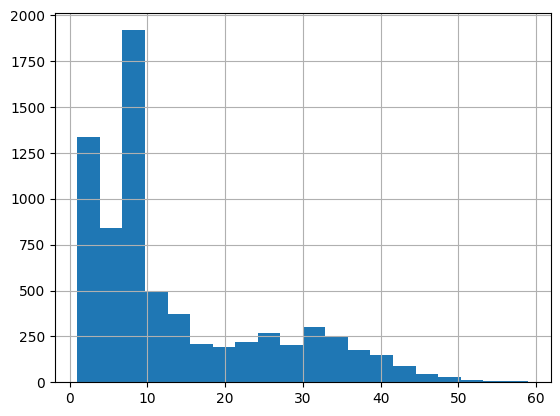

In [7]:
dataset['train'].to_pandas()['tokens'].apply(len).hist(bins=20);

In [12]:
from transformers import AutoTokenizer

# Load the tokenizer for distilbert-based NER
tokenizer = AutoTokenizer.from_pretrained("dslim/distilbert-NER")

# Function to tokenize the input and align labels with tokens
def tokenize_and_align_labels(example):
    # Tokenize 'tokens' while keeping track of word boundaries
    tokenized_inputs = tokenizer(
        example['tokens'], 
        is_split_into_words=True, 
        truncation=True, 
        padding='max_length',
        max_length=64,
    )
    
    # Get the word_ids (mapping from tokens to original words)
    word_ids = tokenized_inputs.word_ids()
    aligned_labels = []

    previous_word_idx = None
    for word_idx in word_ids:
        if word_idx is None:
            aligned_labels.append(-100)  # Special tokens ([CLS], [SEP], etc.)
        elif word_idx != previous_word_idx:
            aligned_labels.append(example['ner_tags'][word_idx])  # Assign the label to the first token of each word
        else:
            aligned_labels.append(-100)  # Subword tokens get label -100

        previous_word_idx = word_idx

    tokenized_inputs["labels"] = aligned_labels
    return tokenized_inputs

# Apply the function to the dataset
tokenized_dataset = dataset.map(tokenize_and_align_labels)



Map: 100%|██████████| 1000/1000 [00:00<00:00, 3937.31 examples/s]


In [13]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'ner_tags', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 7127
    })
    validation: Dataset({
        features: ['id', 'tokens', 'ner_tags', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 1000
    })
})

In [14]:
tokenized_dataset['validation'][0]

{'id': 7127,
 'tokens': ['Jackson,',
  'TN',
  'is',
  'home',
  'to',
  'several',
  'tech',
  'companies.'],
 'ner_tags': [5, 6, 0, 0, 0, 0, 0, 0],
 'input_ids': [101,
  3160,
  117,
  157,
  2249,
  1110,
  1313,
  1106,
  1317,
  13395,
  2557,
  119,
  102,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'attention_mask': [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'labels': [-100,
  5,
  -100,
  6,
  -100,
  0,
  0,
  0,
  0,
  0,
  0,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -1

In [15]:
def postprocess_predictions_and_labels(predictions, references):
    true_predictions = []
    true_labels = []
    cmp_count = 0

    for prediction, reference in zip(predictions, references):
        # Only keep labels that are not -100
        true_labels_example = [label for label in reference if label != -100]
        
        # Align predictions: Remove predictions for which the corresponding reference label is -100
        true_predictions_example = [pred for pred, ref in zip(prediction, reference) if ref != -100]

        # Ensure the length of predictions and labels matches
        if len(true_predictions_example) == len(true_labels_example):
            true_labels.append(true_labels_example)
            true_predictions.append(true_predictions_example)
            cmp_count += 1
        else:
            # Log or handle the error (example-level mismatch)
            # print(f"Skipping example due to mismatch: predictions ({len(true_predictions_example)}), labels ({len(true_labels_example)})")
            continue  # Skip this example

    # Flatten the lists (convert from list of lists to a single list)
    true_predictions = [pred for sublist in true_predictions for pred in sublist]
    true_labels = [label for sublist in true_labels for label in sublist]
    print(f"cmp_count = {cmp_count} out of {len(predictions)}")

    return true_predictions, true_labels


In [16]:
def compute_metrics(p):
    logits, labels = p
    predictions = np.argmax(logits, axis=1)
    
    # Post-process the predictions and labels to remove -100 values
    true_predictions, true_labels = postprocess_predictions_and_labels(predictions, labels)

    # Combine metrics
    accuracy_metric = evaluate.load("accuracy")
    precision_metric = evaluate.load("precision")
    recall_metric = evaluate.load("recall")
    f1_metric = evaluate.load("f1")

    # Calculate metrics
    accuracy = accuracy_metric.compute(predictions=true_predictions, references=true_labels)
    precision = precision_metric.compute(predictions=true_predictions, references=true_labels, average="weighted")
    recall = recall_metric.compute(predictions=true_predictions, references=true_labels, average="weighted")
    f1 = f1_metric.compute(predictions=true_predictions, references=true_labels, average="weighted")

    return {
        "accuracy": accuracy["accuracy"],
        "precision": precision["precision"],
        "recall": recall["recall"],
        "f1": f1["f1"]
    }

In [17]:


# Load the pre-trained model
model = AutoModelForTokenClassification.from_pretrained("dslim/distilbert-NER", num_labels=9)

# Define the LoRA configuration
lora_config = LoraConfig(
    task_type=TaskType.TOKEN_CLS,  # Task type is token classification (NER)
    r=8,  # Low-rank dimension (you can experiment with this)
    lora_alpha=32,  # Scaling factor for LoRA
    lora_dropout=0.1,  # Dropout rate for LoRA
    target_modules=['q_lin']  # LoRA is applied to query layer
)

# Apply LoRA to the model
lora_model = get_peft_model(model, lora_config)


In [18]:


# Define the training arguments
training_args = TrainingArguments(
    output_dir="./results",           # Output directory
    evaluation_strategy="epoch",      # Evaluate at the end of every epoch
    learning_rate=2e-5,               # Learning rate
    per_device_train_batch_size=16,   # Batch size for training
    per_device_eval_batch_size=16,    # Batch size for evaluation
    num_train_epochs=6,               # Number of training epochs
    weight_decay=0.01,                # Weight decay
    logging_dir='./logs',             # Directory for logging
)

# Initialize the Trainer
trainer = Trainer(
    model=lora_model,                  # LoRA-wrapped model
    args=training_args,                # Training arguments
    train_dataset=tokenized_dataset['train'],  # Training dataset
    eval_dataset=tokenized_dataset["validation"],  # Validation dataset (if available)
    tokenizer=tokenizer,               # Tokenizer
    compute_metrics=compute_metrics,  # model perfomance evaluation metric
)

# Fine-tune the model
trainer.train()


/home/jupyter/new_env/lib/python3.10/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.201609,0.088641,0.798935,0.088641,0.156792
2,0.055800,0.128961,0.136943,0.704059,0.136943,0.228659
3,0.041700,0.102654,0.162155,0.692670,0.162155,0.262337
4,0.036100,0.086235,0.178609,0.697997,0.178609,0.283818
5,0.034800,0.078116,0.178344,0.701534,0.178344,0.283735
6,0.033400,0.075506,0.180467,0.701665,0.180467,0.286419


cmp_count = 735 out of 1000


/home/jupyter/new_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


cmp_count = 735 out of 1000


/home/jupyter/new_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


cmp_count = 735 out of 1000


/home/jupyter/new_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


cmp_count = 735 out of 1000


/home/jupyter/new_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


cmp_count = 735 out of 1000


/home/jupyter/new_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


cmp_count = 735 out of 1000


/home/jupyter/new_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


TrainOutput(global_step=2676, training_loss=0.03972271846548859, metrics={'train_runtime': 184.9381, 'train_samples_per_second': 231.223, 'train_steps_per_second': 14.47, 'total_flos': 699786180693504.0, 'train_loss': 0.03972271846548859, 'epoch': 6.0})

In [19]:
import torch
from transformers import AutoTokenizer

# Your text list
text_list = [
    'New York', 'Los Angeles', 'Chicago', 'Philadelphia', 'Dallas',
    'Fort Worth', 'Houston', 'Atlanta', 'Boston', 'Manchester',
    'Washington, D.C.', 'Hagerstown', 'San Francisco', 'Oakland',
    'San Jose'
]

model = trainer.model

# Function to make predictions and group entities
def predict_ner(text_list):
    model.eval()  # Set the model to evaluation mode

    for text in text_list:
        # Tokenize the input text
        inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
        
        # Move inputs to the same device as the model
        inputs = {k: v.to(model.device) for k, v in inputs.items()}
        
        # Perform inference
        with torch.no_grad():
            outputs = model(**inputs)
        
        # Get predictions (logits -> predicted labels)
        predictions = torch.argmax(outputs.logits, dim=-1).cpu().numpy()[0]
        
        # Map the predictions to labels and tokens
        tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0].cpu().numpy())
        ner_labels = [model.config.id2label[pred] for pred in predictions]

        # Group tokens back into entities
        current_entity = []
        current_label = None
        entities = []

        for token, label in zip(tokens, ner_labels):
            # Ignore special tokens like [CLS], [SEP]
            if token in ["[CLS]", "[SEP]"]:
                continue
            # Handle subword tokens (tokens starting with ##)
            if token.startswith("##"):
                current_entity[-1] += token[2:]  # Append the subword without "##"
            elif label.startswith("B-") or (label.startswith("I-") and label != current_label):
                # New entity starts, append the old one
                if current_entity:
                    entities.append(" ".join(current_entity))
                    current_entity = []
                current_entity.append(token)
                current_label = label
            elif label.startswith("I-") and label == current_label:
                # Continue current entity
                current_entity.append(token)
            else:
                # Non-entity token or 'O'
                if current_entity:
                    entities.append(" ".join(current_entity))
                    current_entity = []
                current_label = None

        # Append any remaining entity
        if current_entity:
            entities.append(" ".join(current_entity))

        # Clean up tokens (remove subword tokens and punctuation issues, etc.)
        clean_entities = []
        for entity in entities:
            entity = entity.replace(" ##", "")
            entity = entity.replace(" .", ".")  # Handle punctuation
            entity = entity.replace(" ,", ",")
            clean_entities.append(entity)

        # Print the result for comparison
        print(f"Input: {text}")
        print(f"Predicted entities: {' '.join(clean_entities)}")
        print()

# Run predictions on the text list
predict_ner(text_list)


Input: New York
Predicted entities: New York

Input: Los Angeles
Predicted entities: Los Angeles

Input: Chicago
Predicted entities: Chicago

Input: Philadelphia
Predicted entities: Philadelphia

Input: Dallas
Predicted entities: Dallas

Input: Fort Worth
Predicted entities: Fort Worth

Input: Houston
Predicted entities: Houston

Input: Atlanta
Predicted entities: Atlanta

Input: Boston
Predicted entities: Boston

Input: Manchester
Predicted entities: Manchester

Input: Washington, D.C.
Predicted entities: Washington D . C

Input: Hagerstown
Predicted entities: Hagerstown

Input: San Francisco
Predicted entities: San Francisco

Input: Oakland
Predicted entities: Oakland

Input: San Jose
Predicted entities: San Jose



In [20]:
from transformers import AutoModelForTokenClassification, AutoTokenizer
from peft import PeftModel, PeftConfig

# Load the base model (DistilBERT NER model)
base_model = AutoModelForTokenClassification.from_pretrained("dslim/distilbert-NER")

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained("dslim/distilbert-NER")

# Load the LoRA-adapted model
peft_config = PeftConfig.from_pretrained("results/checkpoint-2676")
lora_model = PeftModel.from_pretrained(base_model, "results/checkpoint-2676")

# Merge the LoRA weights with the base model
merged_model = lora_model.merge_and_unload()  # This merges LoRA into the base model


In [21]:
# Save the merged model and tokenizer
save_dir = "tmp/merged_distilbert_ner"
merged_model.save_pretrained(save_dir)
tokenizer.save_pretrained(save_dir)

('tmp/merged_distilbert_ner/tokenizer_config.json',
 'tmp/merged_distilbert_ner/special_tokens_map.json',
 'tmp/merged_distilbert_ner/vocab.txt',
 'tmp/merged_distilbert_ner/added_tokens.json',
 'tmp/merged_distilbert_ner/tokenizer.json')

In [24]:
# !huggingface-cli whoami

In [24]:
# !huggingface-cli login

In [23]:
# Upload the merged model
merged_model_dir = "tmp/merged_distilbert_ner"
merged_repo_id = "Mozilla/distilbert-NER-LoRA"  # Adjust as needed

merged_model.push_to_hub(merged_repo_id)
tokenizer.push_to_hub(merged_repo_id)


model.safetensors: 100%|██████████| 261M/261M [00:07<00:00, 36.0MB/s] 
No files have been modified since last commit. Skipping to prevent empty commit.


CommitInfo(commit_url='https://huggingface.co/Mozilla/distilbert-NER-LoRA/commit/c2a46d9d4f2efe56a6cf6fd501e221be1438767a', commit_message='Upload tokenizer', commit_description='', oid='c2a46d9d4f2efe56a6cf6fd501e221be1438767a', pr_url=None, repo_url=RepoUrl('https://huggingface.co/Mozilla/distilbert-NER-LoRA', endpoint='https://huggingface.co', repo_type='model', repo_id='Mozilla/distilbert-NER-LoRA'), pr_revision=None, pr_num=None)